In [1]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import numba as nb
import sklearn
import cv2
import os

from time_checker import frequency_based, frequency_based_scipy, edge_based, laplacian_variance, time_it

In [7]:
blurred_folder = "fin_dataset_last/blur/all"
not_blurred_folder = "fin_dataset_last/clear/all"
output_csv_path = "results.csv"

In [8]:
data = [{'path': os.path.join(blurred_folder, img), 'label': 1} for img in os.listdir(blurred_folder)]
data.extend([{'path': os.path.join(not_blurred_folder, img), 'label': 0} for img in os.listdir(not_blurred_folder)])


In [9]:
df = pd.DataFrame(data)
df

,path,label
0,fin_dataset_last/blur/all/M240TP799_CH08202112...,1
1,fin_dataset_last/blur/all/M240TP799_CH08202112...,1
2,fin_dataset_last/blur/all/M240TP799_CH08202112...,1
3,fin_dataset_last/blur/all/M240TP799_CH08202112...,1
4,fin_dataset_last/blur/all/0000000000000000-211...,1
...,...,...
3724,fin_dataset_last/clear/all/0000000000000000-21...,0
3725,fin_dataset_last/clear/all/M240TP799_CH0820211...,0
3726,fin_dataset_last/clear/all/M240TP799_CH0820211...,0
3727,fin_dataset_last/clear/all/M240TP799_CH0820211...,0


In [10]:
@time_it
def laplacian_variance(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

@time_it
@nb.njit
def frequnecy_based_numba(image):
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shifted)
    return np.mean(magnitude_spectrum)

@time_it
def gradient_magnitude(image):
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    return np.mean(gradient_magnitude)

# def frequency_based(image):
#     f_transform = np.fft.fft2(image)
#     f_transform_shifted = np.fft.fftshift(f_transform)
#     magnitude_spectrum = np.abs(f_transform_shifted)
#     return np.mean(magnitude_spectrum)

# def edge_based(image):
#     edges = cv2.Canny(image, 50, 150)
#     return np.sum(edges) / float(image.size)

In [11]:
lap = []
grad = []
freq_numpy = []
freq_scipy = []
freq_numba = []
e_based = []
for img in df['path']:
	bwimg = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
	bwimg = cv2.resize(bwimg, (640, 480))
	lap.append(laplacian_variance(bwimg))
	grad.append(gradient_magnitude(bwimg))
	freq_numpy.append(frequency_based(bwimg))
	freq_scipy.append(frequency_based_scipy(bwimg))
	freq_numba.append(frequnecy_based_numba(bwimg))
	e_based.append(edge_based(bwimg))

df['laplacian'] = [metric for  metric, time in lap]
df['laplacian_ms'] = [time*1000 for  metric, time in lap]
df['gradient_magnitude'] = [metric for  metric, time in grad]
df['gradient_magnitude_ms'] = [time*1000 for  metric, time in grad]

df['frequency_based_numpy'] = [metric for  metric, time in freq_numpy]
df['frequency_based_numpy_ms'] = [time*1000 for  metric, time in freq_numpy]
df['frequency_based_numba'] = [metric for  metric, time in freq_numba]
df['frequency_based_numba_ms'] = [time*1000 for  metric, time in freq_numba]
df['frequency_based_scipy'] = [metric for  metric, time in freq_scipy]
df['frequency_based_scipy_ms'] = [time*1000 for  metric, time in freq_scipy]
df['edge_based'] = [metric for  metric, time in e_based]
df['edge_based_ms'] = [time*1000 for  metric, time in e_based]

<Axes: >

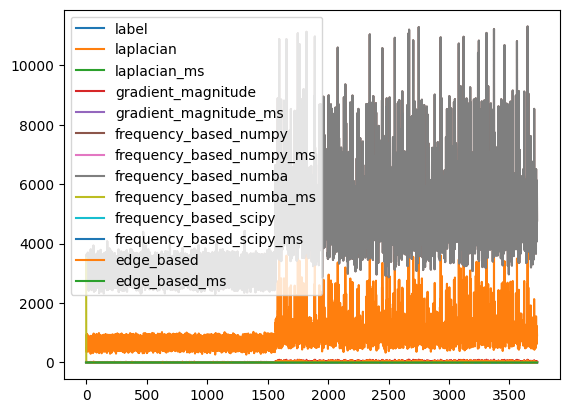

In [12]:
df.plot()

Text(0.5, 1.0, 'Gradient magnitude (Sobel) based algorithm')

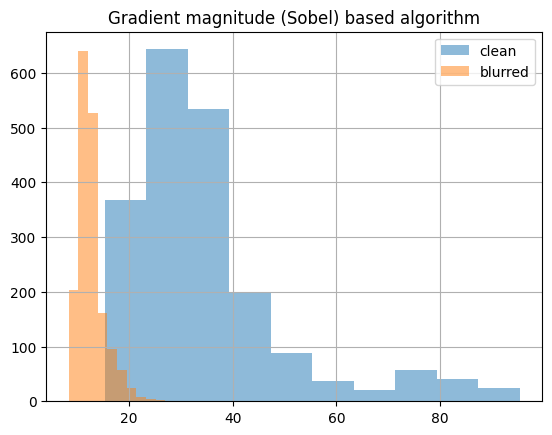

In [50]:
df[df['label'] == 0]['gradient_magnitude'].hist(alpha=0.5)
df[df['label'] == 1]['gradient_magnitude'].hist(alpha=0.5)
plt.legend(['clean',  'blurred'])
plt.title('Gradient magnitude (Sobel) based algorithm')

Text(0.5, 1.0, 'Laplacian based algorithm')

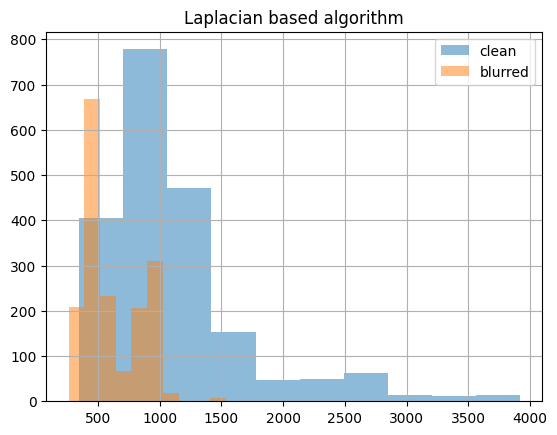

In [48]:
df[df['label'] == 0]['laplacian'].hist(alpha=0.5)
df[df['label'] == 1]['laplacian'].hist(alpha=0.5)
plt.legend(['clean',  'blurred'])
plt.title('Laplacian based algorithm')

Text(0.5, 1.0, 'Edge based (Canny) algorithm')

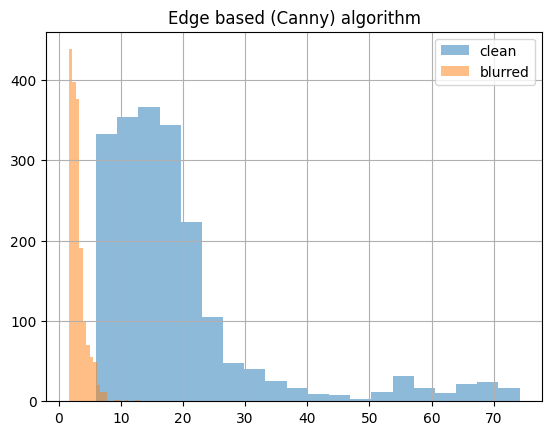

In [51]:
df[df['label'] == 0]['edge_based'].hist(grid=True, alpha=0.5, bins=20)
df[df['label'] == 1]['edge_based'].hist(grid=True, alpha=0.5, bins=20)
plt.legend(['clean',  'blurred'])
plt.title('Edge based (Canny) algorithm')

In [40]:

import shutil
trash_save = 'errors/'
os.makedirs(trash_save, exist_ok=True)
for path in df.loc[(df['label'] == 0) & (df['edge_based'] <= 6.3)]['path']:
    print(path)
    shutil.copy(path, os.path.join(trash_save, path.split('/')[-1]))



fin_dataset_last/clear/all/M240TP799_CH0820211109214533_4500.jpg
fin_dataset_last/clear/all/M240TP799_CH0820211109124516_16000.jpg
fin_dataset_last/clear/all/M240TP799_CH0820211109174523_4000.jpg
fin_dataset_last/clear/all/0000000000000000-211213-080554-105452-000004000510_25100.jpg
fin_dataset_last/clear/all/M240TP799_CH0820211109211533_13000.jpg
fin_dataset_last/clear/all/M240TP799_CH0820211109211533_8500.jpg
fin_dataset_last/clear/all/M240TP799_CH0820211109180003_9000.jpg
fin_dataset_last/clear/all/M240TP799_CH0820211109210013_13000.jpg
fin_dataset_last/clear/all/M240TP799_CH0820211109173003_4500.jpg
fin_dataset_last/clear/all/0000000000000000-211213-080554-105452-000004000510_21586.jpg
fin_dataset_last/clear/all/M240TP799_CH0820211109180003_9500.jpg
fin_dataset_last/clear/all/0000000000000000-211213-080554-105452-000004000510_31375.jpg
fin_dataset_last/clear/all/M240TP799_CH0820211109214533_10500.jpg
fin_dataset_last/clear/all/M240TP799_CH0820211109181523_5500.jpg
fin_dataset_last/

In [34]:
df.loc[(df['label'] == 0) & (df['edge_based'] <= 6), ['label']] = 1
# df.loc[(df['label'] == 0) & (df['edge_based'] <= 5.5)]


Text(0.5, 1.0, 'FFT  based (Fourie) numpy algorithm')

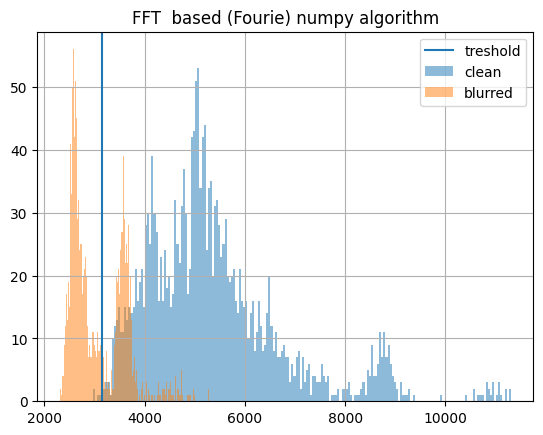

In [52]:
df[df['label'] == 0]['frequency_based_numpy'].hist(alpha=0.5, bins=200)
df[df['label'] == 1]['frequency_based_numpy'].hist(alpha=0.5, bins=200)
plt.axvline(3150)
plt.legend(['treshold', 'clean',  'blurred'])
plt.title('FFT  based (Fourie) numpy algorithm')

In [13]:
import shutil
trash_save = 'errors/tresh'
os.makedirs(trash_save, exist_ok=True)
for path in df.loc[(df['label'] == 1) & (df['frequency_based_numpy'] >3150)]['path']:
    shutil.copy(path, os.path.join(trash_save, path.split('/')[-1]))

Text(0.5, 1.0, 'FFT  based (Fourie) scipy algorithm')

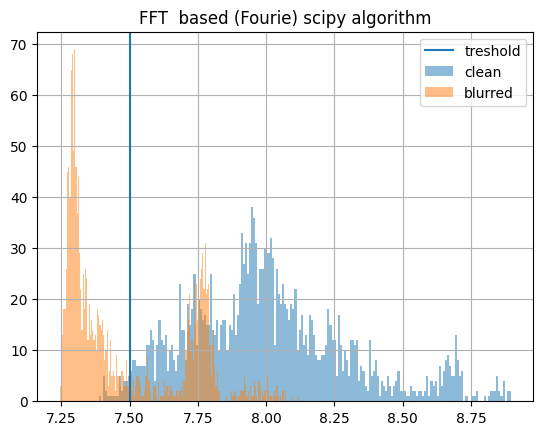

In [53]:
df[df['label'] == 0]['frequency_based_scipy'].hist(alpha=0.5, bins=200)
df[df['label'] == 1]['frequency_based_scipy'].hist(alpha=0.5, bins=200)
plt.axvline(7.5)
plt.legend(['treshold', 'clean',  'blurred'])
plt.title('FFT  based (Fourie) scipy algorithm')

Text(0.5, 1.0, 'FFT  based (Fourie) numba algorithm')

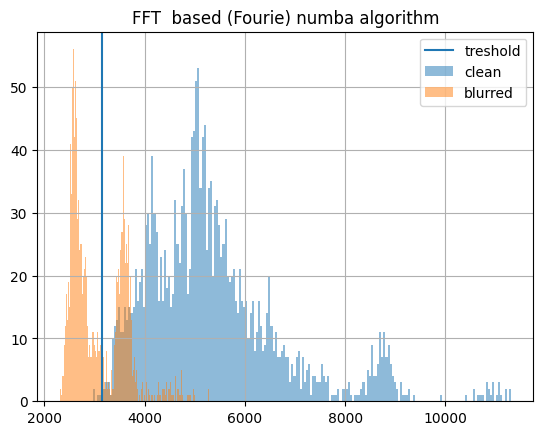

In [54]:
df[df['label'] == 0]['frequency_based_numba'].hist(alpha=0.5, bins=200)
df[df['label'] == 1]['frequency_based_numba'].hist(alpha=0.5, bins=200)
plt.axvline(3150)
plt.legend(['treshold', 'clean',  'blurred'])
plt.title('FFT  based (Fourie) numba algorithm')

In [69]:
# def find_optimal_threshold(y_true, y_scores):
#     # Сортируем предсказанные значения

#     # Вычисляем значения точности и полноты для различных порогов
#     thresholds = np.array([i*0.1 for i in range(40, 70, 1)])
#     print("Tresholds:", thresholds)
#     best_threshold = None
#     best_f1_score = -1

#     for threshold in thresholds:
#         # Применяем порог
#         predicted_labels = (y_scores >= threshold).astype(int)

#         # Вычисляем F1-меру
#         true_positives = np.sum(np.logical_and(predicted_labels == 1, y_true == 1))
#         false_positives = np.sum(np.logical_and(predicted_labels == 1, y_true == 0))
#         false_negatives = np.sum(np.logical_and(predicted_labels == 0, y_true == 1))
#         true_negatives = np.sum(np.logical_and(predicted_labels == 0, y_true == 0))

#         precision = true_positives / (true_positives + false_positives)
#         recall = true_positives / (true_positives + false_negatives)

#         f1_score = 2 * (precision * recall) / (precision + recall)
#         print("f1:", f1_score)
#         # Обновляем лучший порог, если F1-мера выше
#         if f1_score > best_f1_score:
#             best_f1_score = f1_score
#             best_threshold = threshold

#     return best_threshold, best_f1_score

from sklearn.metrics import classification_report

def classify_edge(lst:list):
    treshold = 5
    return [0 if i >= treshold else 1 for i in lst]

y_true = np.array(df['label'])
y_scores = classify_edge(df['edge_based'])
result = classification_report(y_true, y_scores, output_dict=True)
# optimal_threshold, f1_score = find_optimal_threshold(y_true, y_scores)
# print("Optimal threshold:", optimal_threshold)
# print("F1 score:", f1_score)


{'0': {'precision': 0.9300278035217794,
  'recall': 1.0,
  'f1-score': 0.9637454981992798,
  'support': 2007.0},
 '1': {'precision': 1.0,
  'recall': 0.9123112659698026,
  'f1-score': 0.9541451563923475,
  'support': 1722.0},
 'accuracy': 0.9595065701260391,
 'macro avg': {'precision': 0.9650139017608896,
  'recall': 0.9561556329849012,
  'f1-score': 0.9589453272958137,
  'support': 3729.0},
 'weighted avg': {'precision': 0.9623399843572569,
  'recall': 0.9595065701260391,
  'f1-score': 0.9593121947421768,
  'support': 3729.0}}

In [70]:
df.to_csv('processed_results.csv')

In [16]:
heights = []
widths = []
for img in df['path']:
# 	bwimg = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
# 	h, w = bwimg.shape
	heights.append(640)
	widths.append(480)
df['height'] = heights
df['widths'] = widths


In [17]:
df.to_csv('analyze.csv')

In [18]:
df.describe()

,label,laplacian,laplacian_ms,gradient_magnitude,gradient_magnitude_ms,frequency_based_numpy,frequency_based_numpy_ms,frequency_based_numba,frequency_based_numba_ms,frequency_based_scipy,frequency_based_scipy_ms,edge_based,edge_based_ms,height,widths
count,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.0,2736.0
mean,0.412281,736.812990,1.521571,22.753257,3.101015,3972.217219,6.280081,3972.217219,10.064118,7.657046,6.681044,10.005778,0.595233,640.0,480.0
std,0.492335,346.170339,0.176914,10.593867,0.299992,1259.391066,0.562900,1259.391066,75.925897,0.316834,0.532936,7.316326,0.102430,0.0,0.0
min,0.000000,264.153030,1.262188,8.863581,2.699137,2310.164284,5.620003,2310.164284,7.822990,7.244842,5.410910,2.017090,0.453949,640.0,480.0
25%,0.000000,472.316067,1.412094,12.783679,2.929688,2727.593312,5.867422,2727.593312,8.257568,7.332592,6.294847,3.101379,0.518799,640.0,480.0
50%,0.000000,646.860721,1.467347,21.126295,3.007293,3840.641330,6.114125,3840.641330,8.508921,7.635653,6.560802,8.137671,0.568628,640.0,480.0
75%,1.000000,928.437559,1.559794,30.748918,3.156722,5013.089110,6.527662,5013.089110,8.782208,7.931568,6.882668,15.647595,0.642657,640.0,480.0
max,1.000000,2521.631644,2.927303,61.592579,5.521059,8343.038697,11.175394,8343.038697,3979.958057,8.538147,10.981560,38.272412,1.377821,640.0,480.0


In [19]:
df.corr(numeric_only=True)

,label,laplacian,laplacian_ms,gradient_magnitude,gradient_magnitude_ms,frequency_based_numpy,frequency_based_numpy_ms,frequency_based_numba,frequency_based_numba_ms,frequency_based_scipy,frequency_based_scipy_ms,edge_based,edge_based_ms,height,widths
label,1.000000,-0.625774,-0.059897,-0.779328,-0.067851,-0.812805,-0.022981,-0.812805,0.022180,-0.825502,-0.065101,-0.767762,-0.494339,NaN,NaN
laplacian,-0.625774,1.000000,0.027847,0.901960,0.083277,0.915326,0.019884,0.915326,-0.021840,0.888544,0.050612,0.855598,0.552676,NaN,NaN
laplacian_ms,-0.059897,0.027847,1.000000,0.048423,0.327552,0.039857,-0.002119,0.039857,0.020782,0.039980,0.255072,0.051357,0.085004,NaN,NaN
gradient_magnitude,-0.779328,0.901960,0.048423,1.000000,0.081881,0.957131,0.011555,0.957131,-0.021591,0.924183,0.049710,0.974662,0.595800,NaN,NaN
gradient_magnitude_ms,-0.067851,0.083277,0.327552,0.081881,1.000000,0.079919,0.121459,0.079919,0.013213,0.078053,0.103543,0.081319,0.076073,NaN,NaN
frequency_based_numpy,-0.812805,0.915326,0.039857,0.957131,0.079919,1.000000,0.022278,1.000000,-0.021394,0.986806,0.056740,0.911945,0.574461,NaN,NaN
frequency_based_numpy_ms,-0.022981,0.019884,-0.002119,0.011555,0.121459,0.022278,1.000000,0.022278,0.031641,0.021736,0.070829,0.002211,0.151867,NaN,NaN
frequency_based_numba,-0.812805,0.915326,0.039857,0.957131,0.079919,1.000000,0.022278,1.000000,-0.021394,0.986806,0.056740,0.911945,0.574461,NaN,NaN
frequency_based_numba_ms,0.022180,-0.021840,0.020782,-0.021591,0.013213,-0.021394,0.031641,-0.021394,1.000000,-0.021090,-0.045048,-0.018323,-0.010987,NaN,NaN
frequency_based_scipy,-0.825502,0.888544,0.039980,0.924183,0.078053,0.986806,0.021736,0.986806,-0.021090,1.000000,0.058783,0.890990,0.571437,NaN,NaN


In [100]:
from sklearn.preprocessing import StandardScaler

In [101]:
scaler = StandardScaler()

In [102]:
scaler.fit(df.drop(['label', 'path'], axis=1))
scaled_features = scaler.transform(df.drop(['label', 'path'], axis=1))

In [104]:
scaled_data = pd.DataFrame(scaled_features, columns = df.drop(['label', 'path'], axis=1).columns)
scaled_data


,laplacian,gradient_magnitude,frequency_based,edge_based,height,widths
0,-0.666824,-0.782283,-0.805932,-0.841685,0.0,0.0
1,-1.006501,-1.215219,-1.310278,-1.009354,0.0,0.0
2,-0.723646,-0.621682,-0.718774,-0.839416,0.0,0.0
3,-0.666595,-0.778733,-0.709043,-0.828866,0.0,0.0
4,-0.604673,-1.038248,-1.042362,-1.002548,0.0,0.0
...,...,...,...,...,...,...
2731,0.592552,0.903932,0.658493,0.926558,0.0,0.0
2732,-0.201837,-0.063675,-0.036578,-0.262329,0.0,0.0
2733,1.156630,1.470885,1.205783,1.705233,0.0,0.0
2734,0.846410,1.052033,0.791300,1.000750,0.0,0.0


In [108]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

x = scaled_data
y = df['label']

x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.3)

In [115]:
model = KNeighborsClassifier(n_neighbors = 5)

model.fit(x_training_data, y_training_data)

KNeighborsClassifier()

In [116]:
predictions = model.predict(x_test_data)
print(classification_report(y_test_data, predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       477
           1       0.97      0.95      0.96       344

    accuracy                           0.97       821
   macro avg       0.97      0.96      0.97       821
weighted avg       0.97      0.97      0.97       821



In [117]:
print(confusion_matrix(y_test_data, predictions))

[[468   9]
 [ 18 326]]


In [118]:
error_rates = []

In [119]:
for i in np.arange(1, 101):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(x_training_data, y_training_data)
    new_predictions = new_model.predict(x_test_data)
    error_rates.append(np.mean(new_predictions != y_test_data))


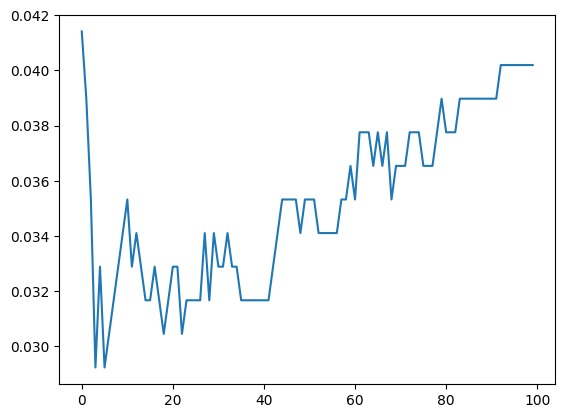

In [120]:
plt.plot(error_rates)

In [121]:
import time
times = []
for i, img in enumerate(df['path']):
	# if i == 1000:
	# 	break
	bwimg = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
	start = time.time()
	lap.append(laplacian_variance(bwimg))
	grad.append(gradient_magnitude(bwimg))
	freq.append(frequency_based(bwimg))
	e_based.append(edge_based(bwimg))
	end = time.time()
	times.append(end - start)

print(f"Mean time: {sum(times)/len(times)}")


KeyboardInterrupt: 